## 1. Objective   : 
*Membuat machine learning yang dapat memprediksi Chest Carcinoma, dengan mengimplementasikan Computer Vision ANN*

## 2. Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading
from google.colab import drive

# Model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir ~/.kaggle  #membuat direktori di dalam root

!cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

!ls ~/.kaggle

kaggle.json


In [5]:
# Mengunduh dataset dari kaggle
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 99% 117M/119M [00:06<00:00, 21.5MB/s]
100% 119M/119M [00:06<00:00, 17.9MB/s]


In [6]:
# Ekstrak dataset lalu disimpan didalam folder images
!unzip -q '/content/chest-ctscan-images.zip' -d images

In [7]:
# Membuat 'main_path' yang berisi direktori 'image'
main_path = '/content/images/Data'

### Akses Folder path

In [8]:
# Membuat direktori
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'valid')

In [9]:
# Menampilkan jumlah data pada data train
print('train set: \n' + '='*50)

train_adenocarcinoma_left = len(os.listdir(os.path.join(train_dir, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')))
train_large_cell_carcinoma_left = len(os.listdir(os.path.join(train_dir, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')))
train_normal = len(os.listdir(os.path.join(train_dir, 'normal')))
train_squamous_cell_carcinoma_left = len(os.listdir(os.path.join(train_dir, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')))

print(f'jumlah adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib= {train_adenocarcinoma_left}')
print(f'jumlah large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa= {train_large_cell_carcinoma_left}')
print(f'jumlah normal= {train_normal}')
print(f'jumlah squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa= {train_squamous_cell_carcinoma_left}')

train set: 
jumlah adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib= 195
jumlah large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa= 115
jumlah normal= 148
jumlah squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa= 155


In [10]:
# Menampilkan jumlah data pada data train untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('test set: \n' + '='*50)

test_adenocarcinoma = len(os.listdir(os.path.join(test_dir, 'adenocarcinoma')))
test_large_cell_carcinoma = len(os.listdir(os.path.join(test_dir, 'large.cell.carcinoma')))
test_normal = len(os.listdir(os.path.join(test_dir, 'normal')))
test_squamous_cell_carcinoma = len(os.listdir(os.path.join(test_dir, 'squamous.cell.carcinoma')))

print(f'jumlah adenocarcinoma= {test_adenocarcinoma}')
print(f'jumlah large.cell.carcinoma= {test_large_cell_carcinoma}')
print(f'jumlah normal= {test_normal}')
print(f'jumlah squamous= {test_squamous_cell_carcinoma}')

test set: 
jumlah adenocarcinoma= 120
jumlah large.cell.carcinoma= 51
jumlah normal= 54
jumlah squamous= 90


In [11]:
print('valid set: \n' + '='*50)

val_adenocarcinoma_left = len(os.listdir(os.path.join(val_dir, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib')))
val_large_cell_carcinoma_left = len(os.listdir(os.path.join(val_dir, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa')))
val_normal = len(os.listdir(os.path.join(val_dir, 'normal')))
val_squamous_cell_carcinoma_left = len(os.listdir(os.path.join(val_dir, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa')))

print(f'jumlah adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib= {val_adenocarcinoma_left}')
print(f'jumlah large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa= {val_large_cell_carcinoma_left}')
print(f'jumlah normal= {val_normal}')
print(f'jumlah squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa= {val_squamous_cell_carcinoma_left}')

valid set: 
jumlah adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib= 23
jumlah large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa= 21
jumlah normal= 13
jumlah squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa= 15


In [12]:
# Mengumpulkan nama file gambar untuk setiap kategori (DR dan No_DR) dari train, test, dan validasi menggunakan glob
train_adenocarcinoma= glob.glob(train_dir+"/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/*.png")
train_carcinoma= glob.glob(train_dir+"/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/*.png")
train_normal = glob.glob(train_dir+"/normal/*.png")
train_squamous = glob.glob(train_dir+"/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/*.png")

In [13]:
test_adenocarcinoma= glob.glob(test_dir+"/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/*.png")
test_carcinoma= glob.glob(test_dir+"/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/*.png")
test_normal = glob.glob(test_dir+"/normal/*.png")
test_squamous = glob.glob(test_dir+"/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/*.png")

In [14]:
val_adenocarcinoma= glob.glob(val_dir+"/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/*.png")
val_carcinoma= glob.glob(val_dir+"/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/*.png")
val_normal = glob.glob(val_dir+"/normal/*.png")
val_squamous = glob.glob(val_dir+"/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/*.png")

### Membuat Data Frame

In [15]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_adenocarcinoma + train_carcinoma + train_normal + train_squamous)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_adenocarcinoma + test_carcinoma + test_normal+ test_squamous)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_adenocarcinoma + val_carcinoma + val_normal+ val_squamous)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [16]:
print(train_df.shape)
train_df.head(2)

(601, 2)


images  \
0  /content/images/Data/train/squamous.cell.carci...   
1     /content/images/Data/train/normal/8 - Copy.png   

                                              label  
0  squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa  
1                                            normal

In [17]:
print(test_df.shape)

(54, 2)


In [18]:
print(val_df.shape)

(72, 2)


 ## 4. Exploratory Data Analysis (EDA)

### Menampilkan Visualisasi Perbandingan Jumlah Data Train untuk Tiap Class / Label

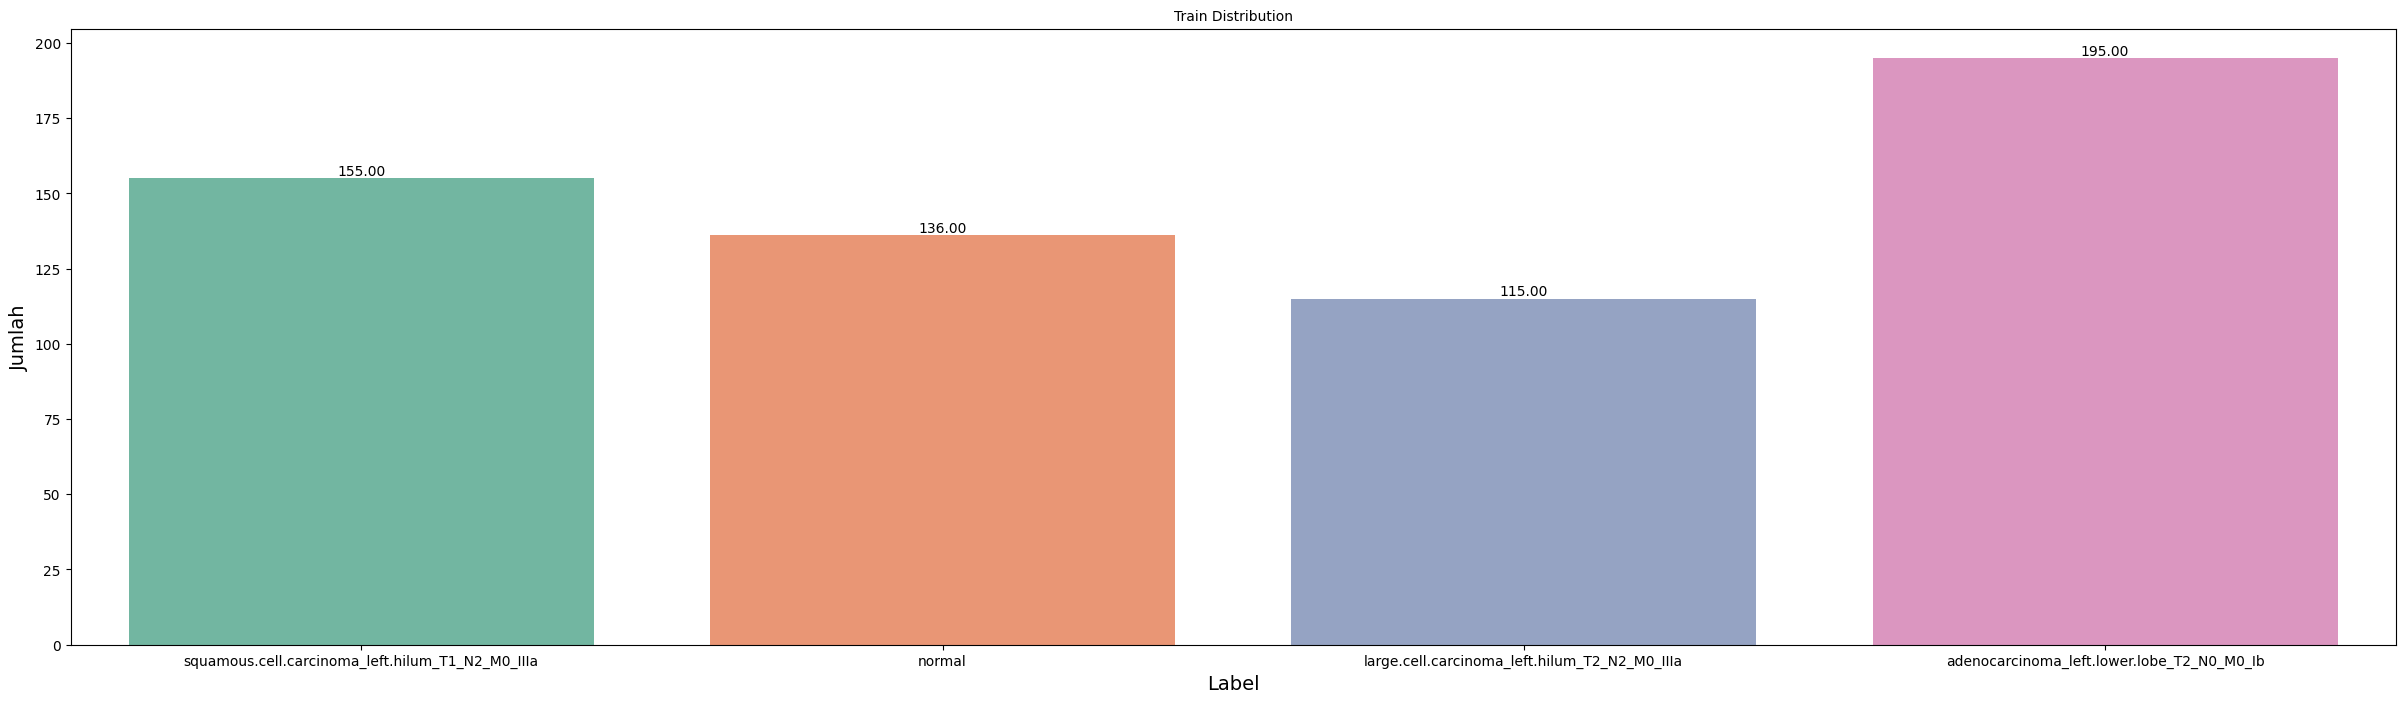

In [19]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(30, 8))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

### Menampilkan Visualisasi Perbandingan Jumlah Data val untuk Tiap Class / Label

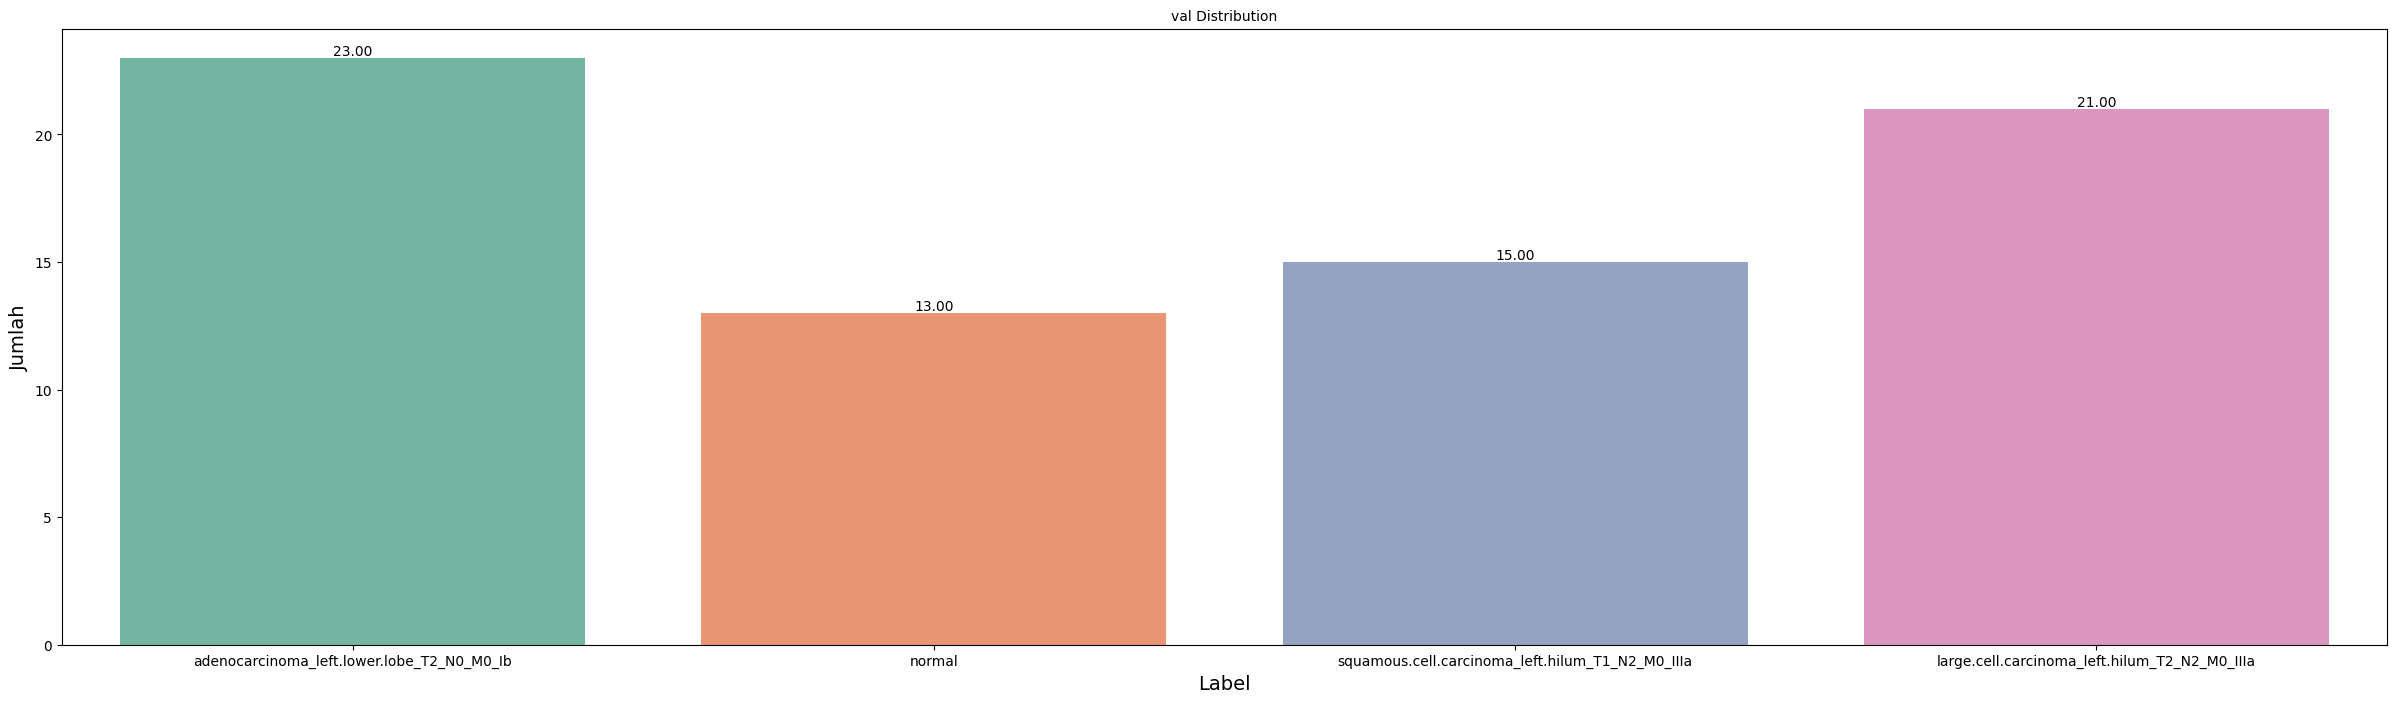

In [20]:
visualize_data(val_df, 'val')

### Menampilkan Visualisasi Gambar *Chest Cancer* untuk Tiap Class / Label

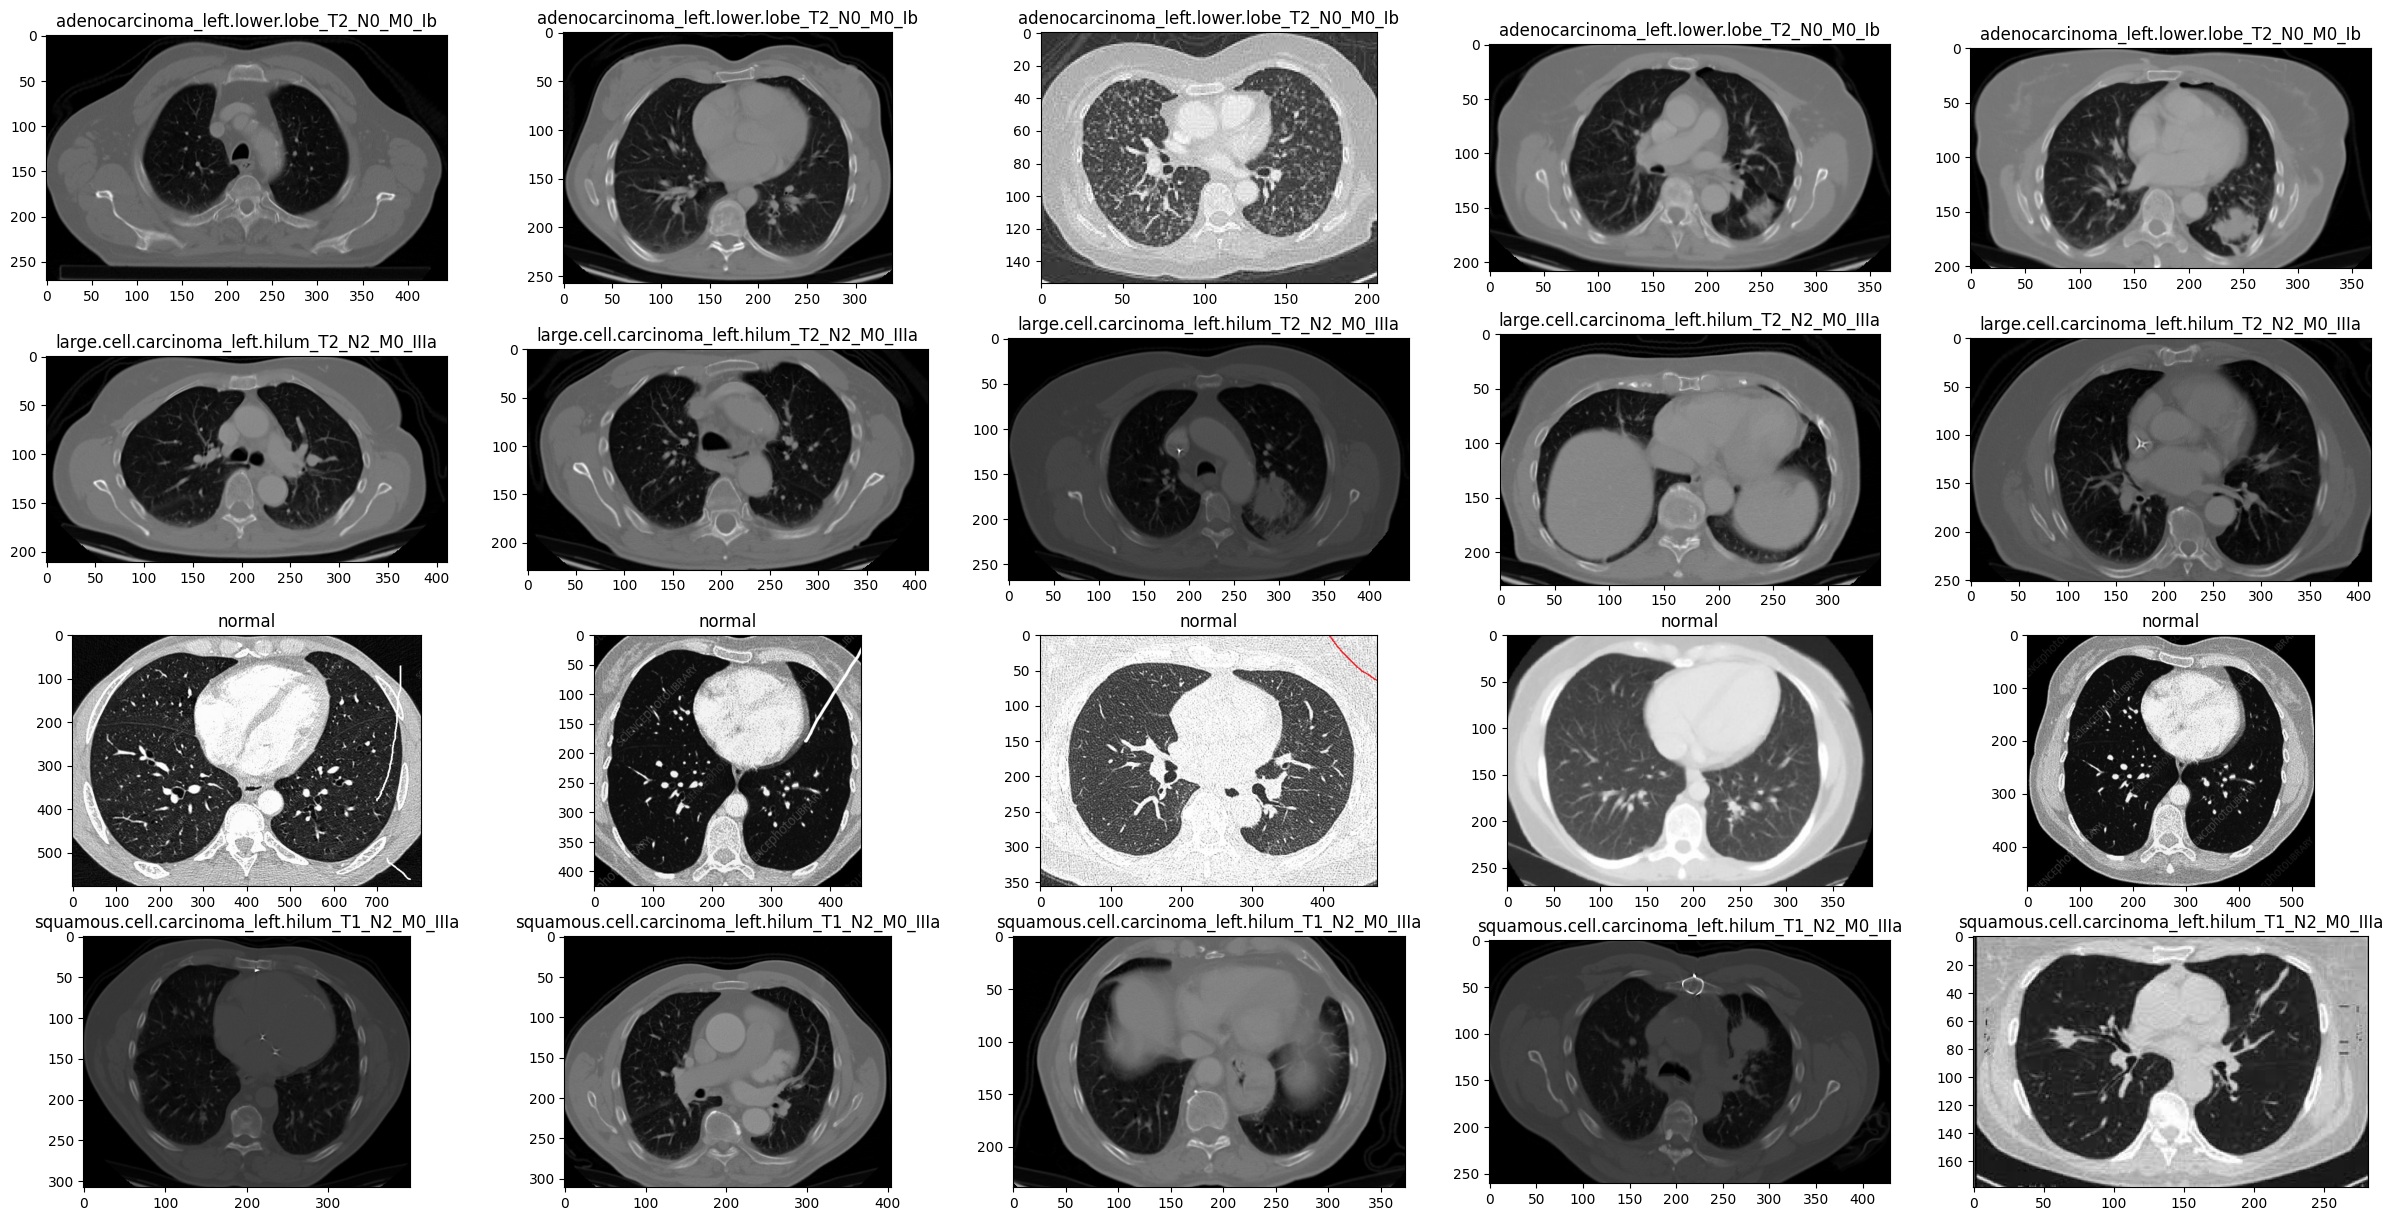

In [21]:
adenocarcinoma_samples = (train_df[train_df['label']=="adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"]['images'].iloc[:5]).tolist()
carcinoma_samples = (train_df[train_df['label']=='large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='normal']['images'].iloc[:5]).tolist()
squamous_samples = (train_df[train_df['label']=='squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(30,15))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(adenocarcinoma_samples + carcinoma_samples + normal_samples + squamous_samples)

### Menampilkan spec, ukuran, dan color mode Gambar *Chest Cancer* Data Train

In [22]:
from PIL import Image
# Membuat fungsi untuk mendapatkan ukuran dari setiap gambar
def size(name):
    width = []
    height = []
    for i in name:
        p = Image.open(i)
        print(p)


In [23]:
# Menampilkan Informasi gambar
size(test_df['images'])

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=581x476 at 0x7D97B3B7D9C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=371x251 at 0x7D97B3B7D7B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=440x345 at 0x7D97B3B7DA20>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=773x523 at 0x7D97B3B7E680>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=371x251 at 0x7D97B3B7E440>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=581x476 at 0x7D97B3B7E560>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=940x627 at 0x7D97B3B7F4F0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=441x341 at 0x7D97B3B7F7C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=441x341 at 0x7D97B3B7F7F0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=731x555 at 0x7D97B3B7E3E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=371x251 at 0x7D97B3B7E770>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=800x552 at 0x7D97B3B7EBC0>
<PIL.PngImagePlugin.PngImageFi

Dari informasi di atas dapat diketahui bahwa gambar memiliki specificasi gambar, color mode, size yang berbeda-beda

## 5. Feature Engineering

### Data Augmentation

In [24]:
# create image generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # normalisasi pixel
    rotation_range=120, # random rotate 120 degrees
    shear_range=50, # memotong gambar
    zoom_range=[0.3,1.5], # random zoom
    )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='categorical',  # 'categorical' multiclass classification
    batch_size= 32,
    shuffle=False,
    seed= 3,
    subset='training')  # Specify training subset

ds_val = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='categorical',
    batch_size= 32,
    shuffle=False,
    seed= 3)

Found 601 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.


In [26]:
df_test = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col='images',
    y_col='label',
    target_size=(400,400),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=3)

Found 54 validated image filenames belonging to 1 classes.


In [27]:
print(ds_train.class_indices)
print(ds_val.class_indices)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


### Hasil Gambar Data Augmentasi

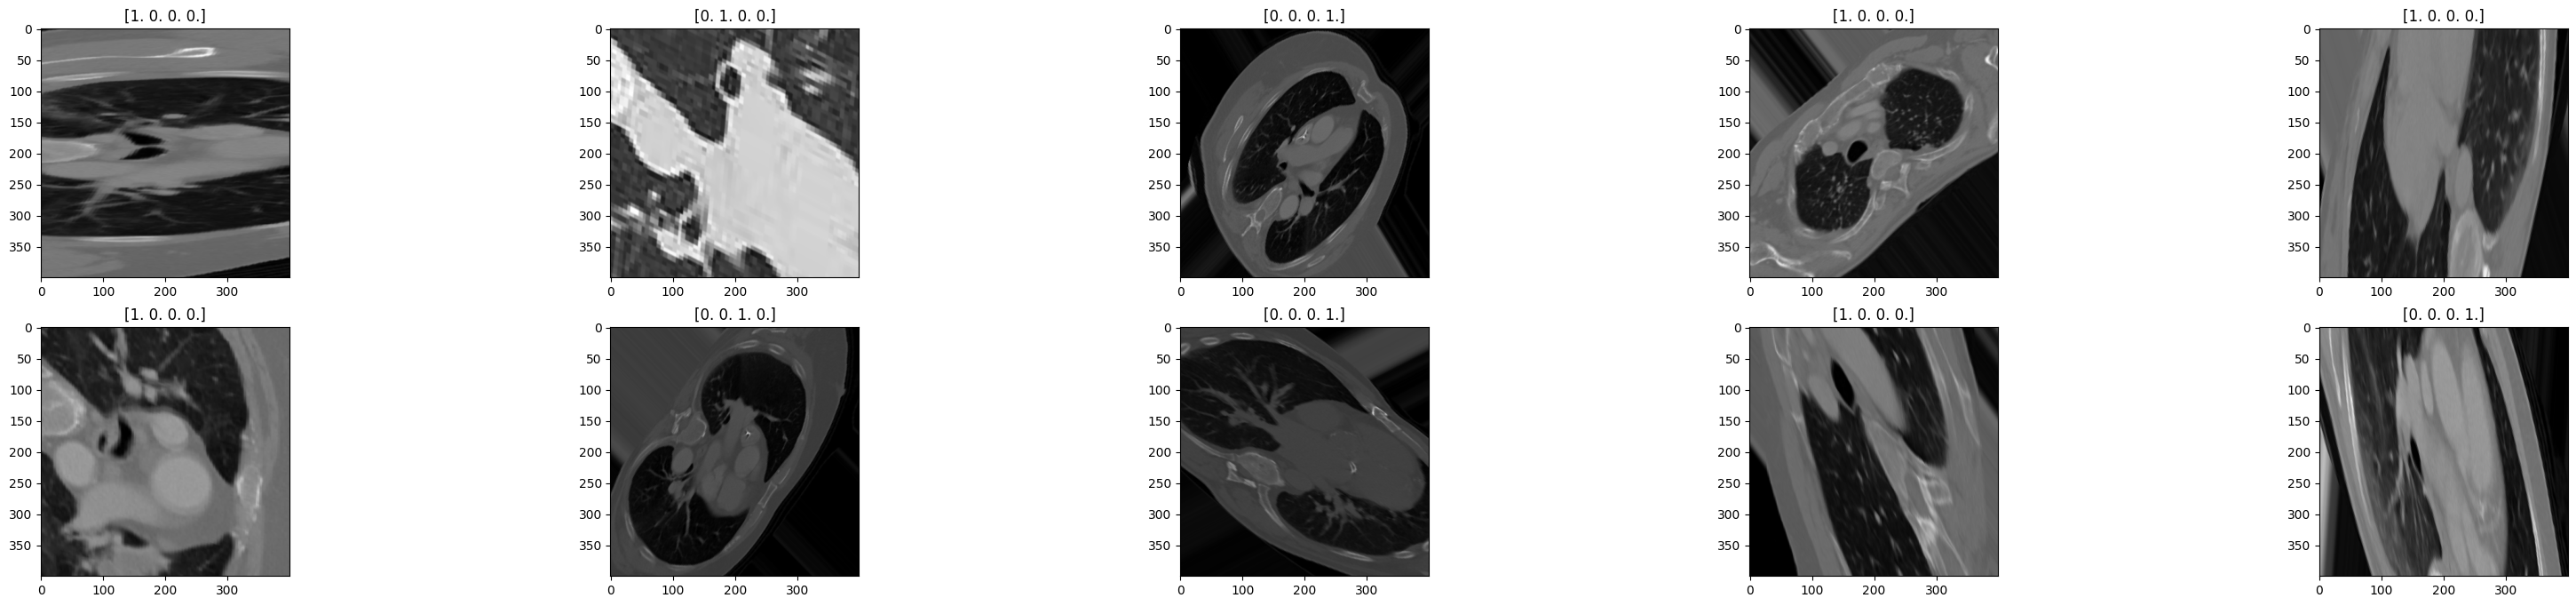

In [28]:
fig,ax = plt.subplots(nrows=2,ncols=5,figsize=(40,8))
n = 0
idx = np.random.randint(len(ds_train.next()[0]), size=10)
for i in range(2):
  for j in range(5):
    img = ds_train.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(ds_train.next()[1][idx[n]])
    n+=1


## 6. CNN Sequential API
### 6.1. Model Definition - Sequential 1

In [29]:

tf.keras.backend.clear_session()
tf.random.set_seed(10)

model = tf.keras.models.Sequential()

# Layer conv 1
model.add(tf.keras.layers.Conv2D(32, (3,3), padding = 'valid', activation='relu', input_shape=(400,400, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)))

# Layer conv 2
model.add(tf.keras.layers.Conv2D(64, (3,3), padding = 'valid',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)))

# Layer conv 3
model.add(tf.keras.layers.Conv2D(128, (3,3),padding = 'valid',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)))

# Flatten
model.add(tf.keras.layers.Flatten()) # lebih bagus flatten dibandingkan global average
model.add(tf.keras.layers.Dropout(0.5)) # mengurangi overfitting

# Hidden Layer
model.add(tf.keras.layers.Dense(512, activation='relu'))

# Output
model.add(tf.keras.layers.Dense(4, activation='softmax')) #output berapa kelas, softmax multiclass

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 128)       0

In [31]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])


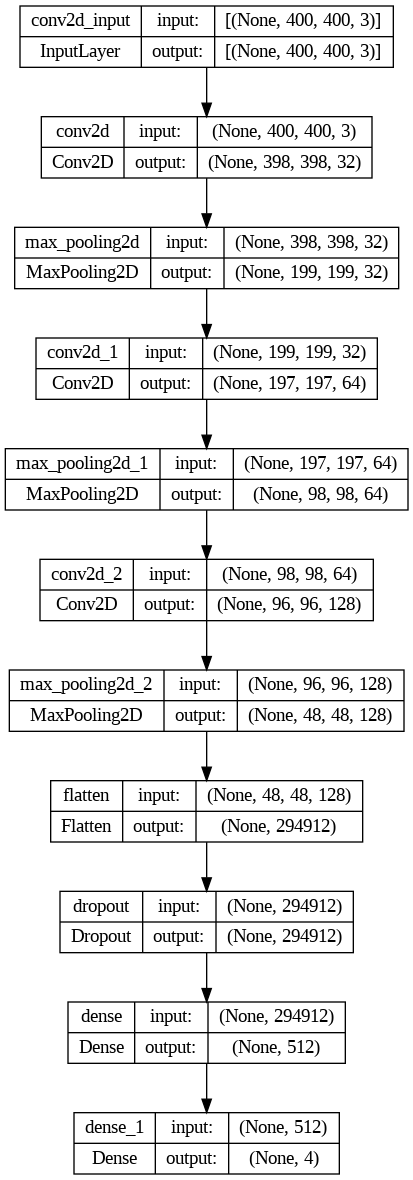

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
    ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
]

### 6.2. Model Training

In [34]:
history= model.fit(ds_train, batch_size= 32,
                   epochs= 25,
                   steps_per_epoch=19,#steps_per_epoch=(len(df_train)/BATCH),
                   validation_steps=2,#validation_steps=(len(ds_val)/BATCH))
                   validation_data= ds_val,
                   callbacks= callbacks)

Epoch 1/25
19/19 [==============================] - 49s 2s/step - loss: 5.0581 - accuracy: 0.2562 - val_loss: 1.2966 - val_accuracy: 0.2344
Epoch 2/25
19/19 [==============================] - 37s 2s/step - loss: 1.2268 - accuracy: 0.4376 - val_loss: 1.1703 - val_accuracy: 0.4219
Epoch 3/25
19/19 [==============================] - 44s 2s/step - loss: 1.0845 - accuracy: 0.4875 - val_loss: 0.9123 - val_accuracy: 0.5625
Epoch 4/25
19/19 [==============================] - 41s 2s/step - loss: 1.0339 - accuracy: 0.5358 - val_loss: 0.8968 - val_accuracy: 0.5781
Epoch 5/25
19/19 [==============================] - 25s 1s/step - loss: 0.9894 - accuracy: 0.5408 - val_loss: 1.0082 - val_accuracy: 0.4844
Epoch 6/25
19/19 [==============================] - 27s 1s/step - loss: 0.9766 - accuracy: 0.5790 - val_loss: 0.9094 - val_accuracy: 0.5312
Epoch 7/25
19/19 [==============================] - 28s 1s/step - loss: 1.0121 - accuracy: 0.5058 - val_loss: 0.9992 - val_accuracy: 0.4531


hasil akurasi dari model sequential 1 hanya dapat memprediksi dengan akurasi 50.58% dan dengan nilai loss yang cukup tinggi 99%

### 6.3. Model Evaluation

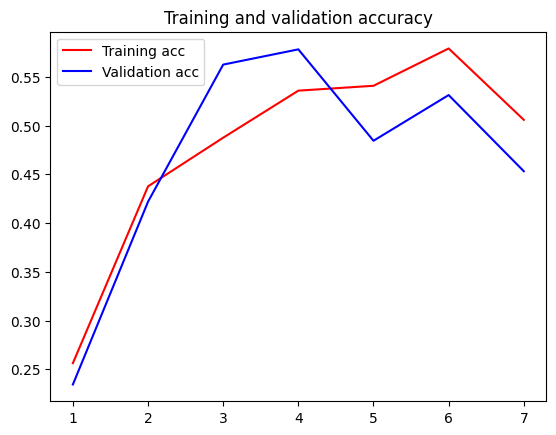

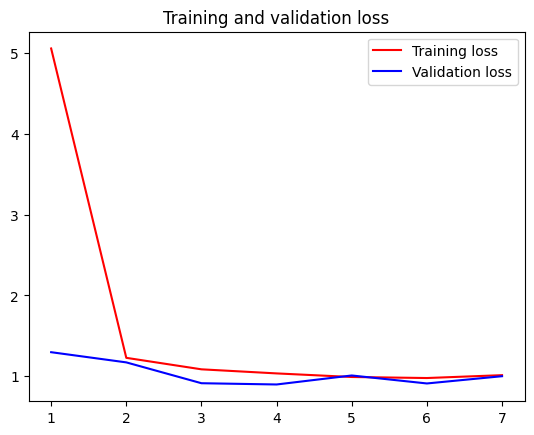

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

terlihat bahwa model mengalami penurunan untuk akurasi dan val pada saat tahap epoch terakhir

### 7.A. CNN Improvement Sequential API
### 7.A.1. Model Definition - Sequential 2 menggunakan Transfer Learning

### Transfer Learning
model ini sequential dengan transfer learning Xception
```tf.keras.applications.xception.Xception(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)```

In [36]:
# transfer learning


tf.keras.backend.clear_session()
tf.random.set_seed(10)

# callback
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 4),
    ModelCheckpoint('best1.hdf5', monitor='val_loss', save_best_only=True)
]

pretrained_model = tf.keras.applications.Xception(include_top= False,
                                                  input_shape=(400,400,3),
                                                  pooling='avg',
                                                  classifier_activation='softmax')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [37]:
# Create the model

model1 = Sequential()
model1.add(pretrained_model)

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))

In [38]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21140780 (80.65 MB)
Trainable params: 279300 (1.07 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


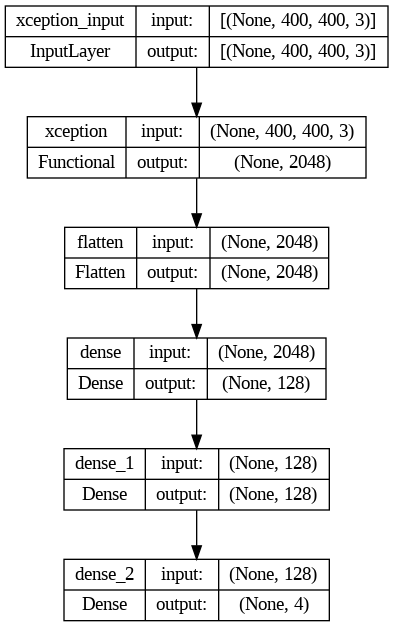

In [39]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [40]:
model1.compile(optimizer=keras.optimizers.AdamW(learning_rate=3e-4),
               loss='categorical_crossentropy', metrics=['accuracy'] )


### 7.A.2. Model Training

In [41]:
history1= model1.fit(ds_train, batch_size= 32,
                   epochs= 40,
                   steps_per_epoch=19,
                   validation_steps=2,
                   validation_data= ds_val,
                   callbacks= callbacks1)

Epoch 1/40
19/19 [==============================] - 43s 2s/step - loss: 1.3185 - accuracy: 0.3627 - val_loss: 1.2651 - val_accuracy: 0.4531
Epoch 2/40
19/19 [==============================] - 29s 2s/step - loss: 1.1415 - accuracy: 0.4692 - val_loss: 1.1175 - val_accuracy: 0.4375
Epoch 3/40
19/19 [==============================] - 29s 2s/step - loss: 1.0516 - accuracy: 0.4958 - val_loss: 1.0319 - val_accuracy: 0.4688
Epoch 4/40
19/19 [==============================] - 30s 2s/step - loss: 1.0051 - accuracy: 0.5092 - val_loss: 0.9952 - val_accuracy: 0.4531
Epoch 5/40
19/19 [==============================] - 29s 1s/step - loss: 0.9738 - accuracy: 0.5474 - val_loss: 1.0139 - val_accuracy: 0.5000
Epoch 6/40
19/19 [==============================] - 30s 2s/step - loss: 0.9779 - accuracy: 0.5275 - val_loss: 1.0013 - val_accuracy: 0.4375
Epoch 7/40
19/19 [==============================] - 45s 2s/step - loss: 0.9462 - accuracy: 0.5441 - val_loss: 0.9764 - val_accuracy: 0.4844
Epoch 8/40
19/19 [==

model ini memiliki akurasi 60% dan dengan loss yang cukup tinggi 99%

### 7.A.3. Model Evaluation

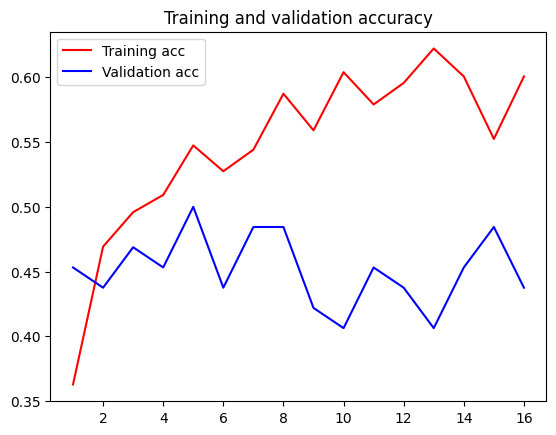

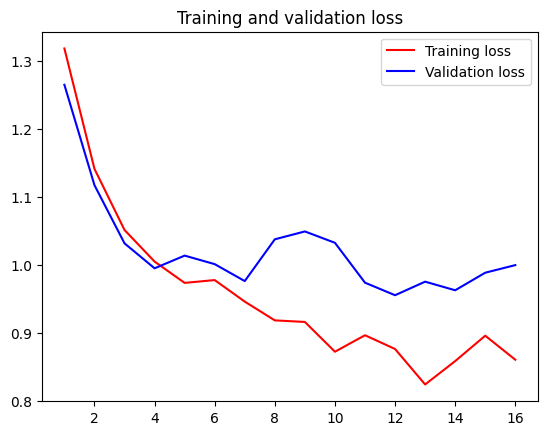

In [42]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

akurasi antara training lebih besar dibandingkan validasi dengan jarak cukup jauh

### 7.B. CNN Improvement Functional API
### 7.B.1. Model Definition

convolutional neural network (CNN) menggunakan functional - TensorFlow Keras

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense


tf.keras.backend.clear_session()
tf.random.set_seed(10)

# Definisi Input layer
input_shape_img = Input(shape=(400, 400, 3))

# Convolutional layer
conv1 = Conv2D(32, (3, 3), activation='relu')(input_shape_img)

# MaxPooling layer
maxpool1 = MaxPooling2D((2, 2))(conv1)

# Flatten layer
flatten = Flatten()(maxpool1)

# Dense layer (fully connected)
dense1 = Dense(128, activation='relu')(flatten)

# Output layer
output = Dense(4, activation='softmax')(dense1)

# Membuat model fungsional
model2 = tf.keras.Model(inputs=input_shape_img, outputs=output)

# Menampilkan ringkasan arsitektur model
model2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1267232)           0         
                                                                 
 dense (Dense)               (None, 128)               162205824 
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                             

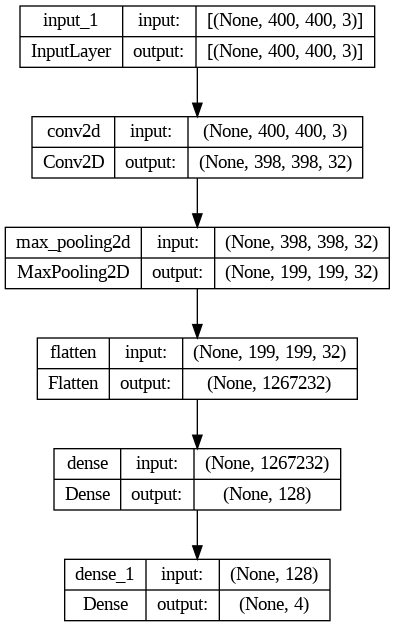

In [44]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [45]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
               loss='categorical_crossentropy', metrics=['accuracy'] )


### 7.B.2. Model Training

In [46]:
# callback
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 4),
    ModelCheckpoint('best2.hdf5', monitor='val_loss', save_best_only=True)
]

history2= model2.fit(ds_train, batch_size= 32,
                   epochs= 40,
                   steps_per_epoch=19,
                   validation_steps=2,
                   validation_data= ds_val,
                   callbacks= callbacks2)

Epoch 1/40
19/19 [==============================] - 35s 2s/step - loss: 114.5239 - accuracy: 0.2329 - val_loss: 4.0375 - val_accuracy: 0.2188
Epoch 2/40
19/19 [==============================] - 32s 2s/step - loss: 4.5275 - accuracy: 0.2712 - val_loss: 1.3063 - val_accuracy: 0.4844
Epoch 3/40
19/19 [==============================] - 26s 1s/step - loss: 2.2202 - accuracy: 0.3161 - val_loss: 1.5131 - val_accuracy: 0.2344
Epoch 4/40
19/19 [==============================] - 37s 2s/step - loss: 1.3238 - accuracy: 0.3910 - val_loss: 1.0760 - val_accuracy: 0.4531
Epoch 5/40
19/19 [==============================] - 27s 1s/step - loss: 1.3097 - accuracy: 0.4093 - val_loss: 3.2087 - val_accuracy: 0.2031
Epoch 6/40
19/19 [==============================] - 28s 1s/step - loss: 1.3053 - accuracy: 0.4692 - val_loss: 1.5922 - val_accuracy: 0.4531
Epoch 7/40
19/19 [==============================] - 35s 2s/step - loss: 1.1560 - accuracy: 0.4842 - val_loss: 1.0097 - val_accuracy: 0.4375
Epoch 8/40
19/19 [

model fungsional ini memiliki akurasi 51% dengan loss cukup tinggi yaitu 109%

### 7.B.3. Model Evaluation

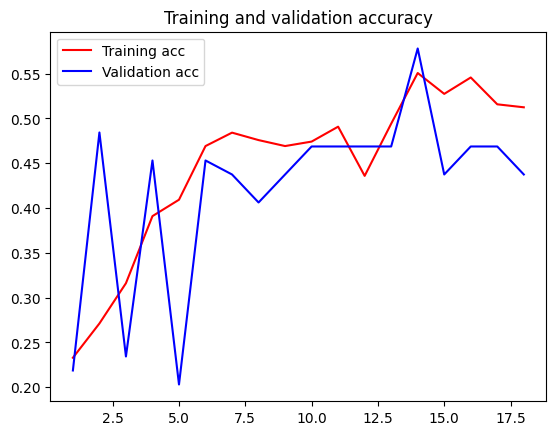

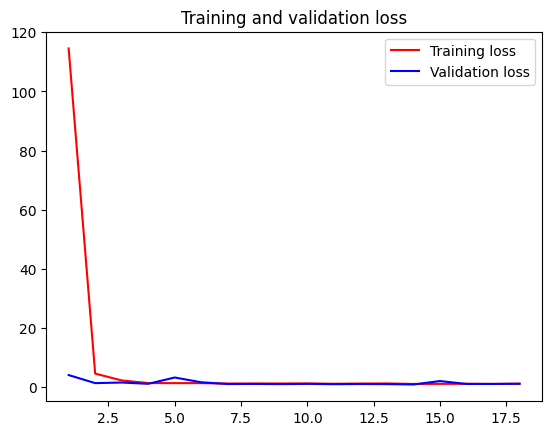

In [47]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

terlihat hasilnya dari model ini tidak stabil, namun training dan validation loss nya cukup rendah

Model Fungsional

In [48]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

tf.keras.backend.clear_session()
tf.random.set_seed(10)

inputs = tf.keras.Input(shape=(400,400,3))
normalized_inputs = tf.keras.layers.BatchNormalization()(inputs)

# Convolutional layers
conv2d_01 = tf.keras.layers.Conv2D(32, (3,3), activation='relu') (inputs)
batch_norm_01 = tf.keras.layers.BatchNormalization() (conv2d_01)
max_pool_01 = tf.keras.layers.MaxPooling2D(2, 2) (batch_norm_01)

conv2d_02 = tf.keras.layers.Conv2D(64, (3,3), activation='relu') (max_pool_01)
batch_norm_02 = tf.keras.layers.BatchNormalization() (conv2d_02)
max_pool_02 = tf.keras.layers.MaxPooling2D(2,2) (batch_norm_02)

conv2d_03 = tf.keras.layers.Conv2D(64, (3,3), activation='relu') (max_pool_02)
batch_norm_03 = tf.keras.layers.BatchNormalization() (conv2d_03)
max_pool_03 = tf.keras.layers.MaxPooling2D(2,2) (batch_norm_03)

flatten = tf.keras.layers.Flatten() (max_pool_02)

dense_01 = tf.keras.layers.Dense(64, activation='relu') (flatten)
dropout = tf.keras.layers.Dropout(.3) (dense_01)

dense_02 = tf.keras.layers.Dense(32, activation='relu') (dropout)
dropout = tf.keras.layers.Dropout(0.5) (dense_02)

dense_03 = tf.keras.layers.Dense(32, activation='relu') (dropout)
dropout = tf.keras.layers.Dropout(0.5) (dense_03)

dense_04 = tf.keras.layers.Dense(32, activation='relu') (dropout)
dropout = tf.keras.layers.Dropout(0.5) (dense_04)

outputs = tf.keras.layers.Dense(4, activation='softmax') (dropout)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 398, 398, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 batch_normalization_2 (Bat  (None, 197, 197, 64)      256   

In [49]:
model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
               loss='categorical_crossentropy', metrics=['accuracy'] )

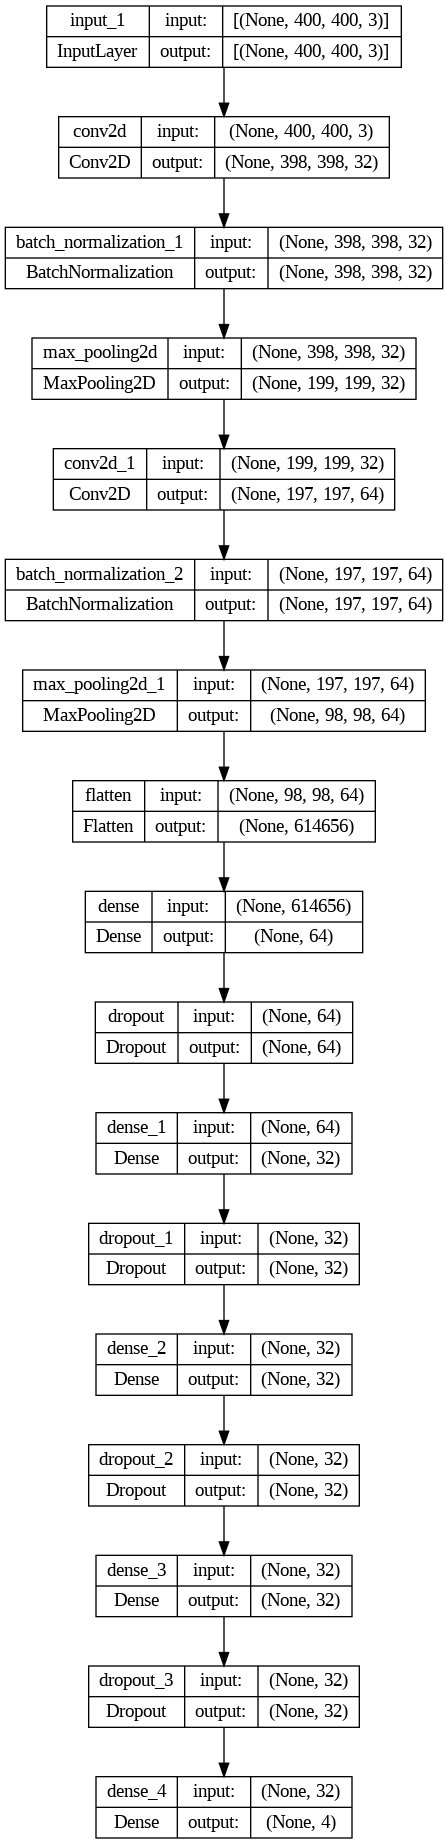

In [50]:
tf.keras.utils.plot_model(model3, show_shapes=True)

In [51]:
%%time
# callback
callbacks3 = [
    EarlyStopping(monitor='val_loss', patience= 4),
    ModelCheckpoint('best3.hdf5', monitor='val_loss', save_best_only=True)
]

history3= model3.fit(ds_train, batch_size= 32,
                   epochs= 40,
                   #steps_per_epoch=19,
                   validation_steps=2,
                   validation_data= ds_val,
                   callbacks= callbacks3)

Epoch 1/40
19/19 [==============================] - 37s 2s/step - loss: 133.5051 - accuracy: 0.2479 - val_loss: 4.1200 - val_accuracy: 0.2812
Epoch 2/40
19/19 [==============================] - 44s 2s/step - loss: 73.8685 - accuracy: 0.2696 - val_loss: 3.6845 - val_accuracy: 0.2188
Epoch 3/40
19/19 [==============================] - 29s 1s/step - loss: 37.8193 - accuracy: 0.2712 - val_loss: 4.5728 - val_accuracy: 0.2344
Epoch 4/40
19/19 [==============================] - 28s 1s/step - loss: 19.7907 - accuracy: 0.3211 - val_loss: 8.4651 - val_accuracy: 0.2188
Epoch 5/40
19/19 [==============================] - 28s 1s/step - loss: 8.5314 - accuracy: 0.3111 - val_loss: 5.3177 - val_accuracy: 0.2500
Epoch 6/40
19/19 [==============================] - 30s 2s/step - loss: 4.4314 - accuracy: 0.3361 - val_loss: 3.4775 - val_accuracy: 0.2188
Epoch 7/40
19/19 [==============================] - 27s 1s/step - loss: 4.0079 - accuracy: 0.3311 - val_loss: 3.4521 - val_accuracy: 0.1875
Epoch 8/40
19/1

metode ini tidak cukup baik dikarenakan akurasi sangat rendah 34% dengan loss yang sangat tinggi

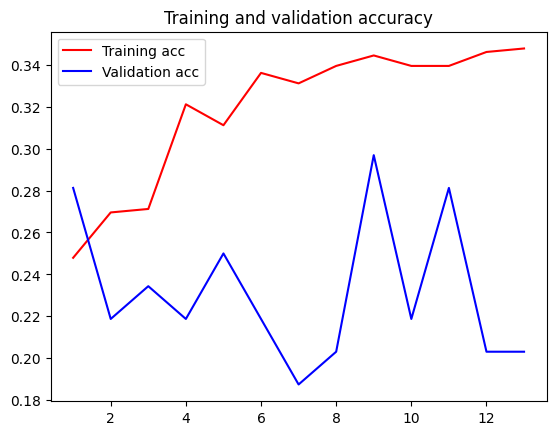

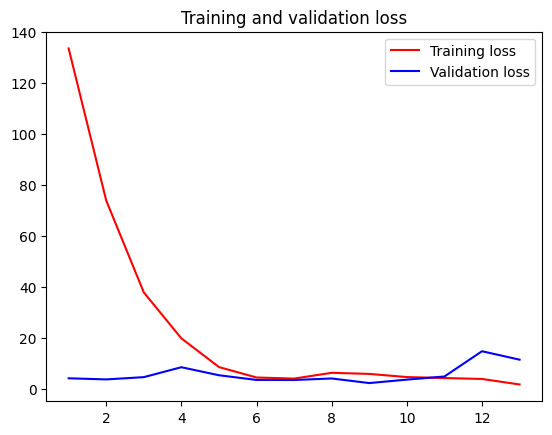

In [52]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

hasilnya akurasi data validasinya sangat tidak stabil

In [68]:
test_loss_eff, test_acc_eff = model.evaluate(df_test, verbose=2)
print('test accuracy sequential1:', test_acc_eff)
print('test loss sequential1 :', test_loss_eff)

2/2 - 1s - loss: 13.3718 - accuracy: 0.0000e+00 - 1s/epoch - 535ms/step
test accuracy sequential1: 0.0
test loss sequential1 : 13.371849060058594


In [67]:
test_loss_eff, test_acc_eff = model1.evaluate(df_test, verbose=2)
print('test ccuracy sequantial2:', test_acc_eff)
print('test loss sequential2:', test_loss_eff)

2/2 - 1s - loss: 11.1393 - accuracy: 0.3333 - 1s/epoch - 576ms/step
test ccuracy sequantial2: 0.3333333432674408
test loss sequential2: 11.13930892944336


In [69]:
test_loss_eff, test_acc_eff = model2.evaluate(df_test, verbose=2)
print('test accuracy (functional1):', test_acc_eff)
print('test loss (functional1):', test_loss_eff)

2/2 - 1s - loss: 21.1297 - accuracy: 0.1852 - 1s/epoch - 633ms/step
test accuracy (functional1): 0.18518517911434174
test loss (functional1): 21.129724502563477


hasil akurasi dari test lebih tinggi pada model ke-dua walaupun juga lossnya cukup tinggi

In [70]:
test_loss_eff, test_acc_eff = model3.evaluate(df_test, verbose=2)
print('test accuracy (functional2):', test_acc_eff)
print('test loss (functional2):', test_loss_eff)

2/2 - 2s - loss: 30.6650 - accuracy: 0.0000e+00 - 2s/epoch - 847ms/step
test accuracy (functional2): 0.0
test loss (functional2): 30.66502571105957


In [57]:
df_test.class_indices

{'normal': 0}

In [58]:
y_test = test_df['label'].apply(lambda x:0).values

In [59]:
class_names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa','normal',
               'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

from sklearn.metrics import classification_report

# Assuming y_test contains the true labels and y_pred contains the predicted labels

# Get the probability
y_pred_proba = model2.predict(df_test)

# Get class with maximum probability
y_pred = np.argmax(y_pred_proba, axis=-1)

# Display Classification Report
print(classification_report(y_test, y_pred))


2/2 [==============================] - 1s 391ms/step
              precision    recall  f1-score   support

           0       1.00      0.19      0.31        54
           2       0.00      0.00      0.00         0

    accuracy                           0.19        54
   macro avg       0.50      0.09      0.16        54
weighted avg       1.00      0.19      0.31        54



akurasinya cukup rendah hanya 19%

## 8. Model Saving

model saving telah tersave pada saat callback best2.hdf5

## 9. Model Inference

ada pada file : P2G7_inference

contoh testing dengan upload gambar

In [60]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

Saving Adenocarcinoma-in-situ-Axial-contrast-enhanced-chest-CT-scan-with-lung-window.png to Adenocarcinoma-in-situ-Axial-contrast-enhanced-chest-CT-scan-with-lung-window.png


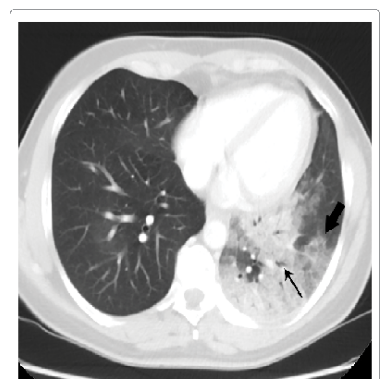

1/1 [==============================] - 0s 211ms/step
Prediction is a normal


In [61]:
import numpy as np
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  # Prediksi dengan mengunggah gambar
  path = fn
  img =  tf.keras.utils.load_img(path, target_size=(400,400)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = tf.keras.utils.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])

  classes = model2.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  idx = np.argmax(classes)
  clas = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib','large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa','normal','squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
  print('Prediction is a {}'.format(clas[idx]))


## 10. Pengambilan Kesimpulan

- Metric yang dipilih adalah metric akurasi dikarenakan data multiclass, lebih fokus untuk menilai akurasi dari hasil modelnya

- Model yang paling bagus adalah model fungsional tensor flow dengan optimizer optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)

- Kecenderungan hasil yang lebih baik ialah model yang lebih simple tanpa terlalu banyak layer, seperti model sequential - transfer learning dan model fungsional yang pertama

- Datanya tidak terlalu baik dikarenakan tiap kelas datanya tidak sama (imbalance) banyak dan modelnya tidak banyak belajar karena datanya terlalu sedikit

note: saat menjalankan menggunakan V100 atau A100, model 2 terlihat sangat baik hasilnya dibandingkan dengan model lainnya namun saat di-run ulang menggunakan T4GPU hasilnya tidak stabil

